In [6]:
import matplotlib.pyplot as plt
import scipy.optimize
import jax
from jax.nn import softmax
from jax import grad, jit
import jax.numpy as jnp
from jax.experimental import optimizers
import time
%run Dendrogram.ipynb

In [2]:
def energy(links, separation_matrices, masses, sizes, weights):
    def momentums_in(frame_num):
        separation_mat = separation_matrices[frame_num-1]
        link_mat = links[frame_num-1]
        mass_in = masses[frame_num-1]
        mass_split = mass_in[:, None] * softmax(link_mat, axis=1)
        momentum = separation_mat * mass_split[:, :-1]
        return jnp.sum(momentum, axis=1)

    def momentums_out(frame_num):
        separation_mat = separation_matrices[frame_num]
        link_mat = links[frame_num]
        mass_out = masses[frame_num]
        mass_split = mass_out[:, None] * softmax(link_mat, axis=1)
        momentum = separation_mat * mass_split[:, :-1]
        return jnp.sum(momentum, axis=2)
    
    def entropy(frame_num):
        link_mat = links[frame_num]
        fracs = softmax(link_mat, axis=1)[:, :-1] + 1e-7
        entropy_terms = -fracs * jnp.log(fracs)
        return jnp.sum(entropy_terms)
        

    E = 0
    c0 = 1
    c1 = 1

    for t in range(1, len(links)):
        p1 = momentums_in(t)
        p2 = momentums_out(t)
        p1_norm = jnp.linalg.norm(p1, axis=0) + 1
        p2_norm = jnp.linalg.norm(p2, axis=0) + 1
        angle_term = -2 * jnp.sum(p1*p2, axis=0)/(p1_norm*p2_norm)
        inertia_term = p1_norm/p2_norm + p2_norm/p1_norm
        bullet_cost = angle_term + c0*inertia_term 
        E += jnp.sum(bullet_cost * weights[t])
    
    for t in range(0, len(links)):
        E += c1 * entropy(t)

    return E

def process_dendrograms(dendrograms, thresh):
    link_matrices = []
    separation_matrices = []
    for t in range(len(dendrograms)-1):
        cur_sz = dendrograms[t].size
        next_sz = dendrograms[t+1].size
        separation_mat = np.empty((2, cur_sz, next_sz))
        link_mat = np.zeros((cur_sz, next_sz + 1))
        link_mat[:, -1] = 1
        for i, j in np.ndindex(cur_sz, next_sz):
            sep = dendrograms[t+1].branches[j].loc - dendrograms[t].branches[i].loc
            separation_mat[:, i, j] = sep
            if np.linalg.norm(sep) < thresh:
                link_mat[i, j] = 1
        link_matrices.append(link_mat)
        separation_matrices.append(separation_mat)
    
    def sigm(x, a=0.5, b=0.1):
        return 1. / (1. + np.exp((a-x)/b))
    masses = []
    sizes = []
    weights = []
    for d in dendrograms:
        dendro_mass = np.asarray([b.mass for b in d.branches])
        masses.append(dendro_mass)
        dendro_sz = np.asarray([b.vol for b in d.branches])
        sizes.append(dendro_sz)
        dendro_wts = np.asarray([sigm(b.mass_frac) for b in d.branches])
        weights.append(dendro_wts)
    return link_matrices, separation_matrices, masses, sizes, weights

In [7]:
fn = 3
dendros = []
for frame_num in range(fn, fn+4):
#     orig = cv2.imread("test_images/tracer/{}.png".format(frame_num),
#                       cv2.IMREAD_GRAYSCALE)
#     orig = orig[50:825, 125:900]
#     orig = cv2.resize(orig, (300, 300))
    orig = cv2.imread("gen/{:02d}.png".format(frame_num), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    im = cv2.GaussianBlur(orig, (3, 3), cv2.BORDER_CONSTANT)
    d = make_dendrogram(-im, frame_num)
    dendros.append(d)

In [8]:
energy = jit(energy, static_argnums=(1, 2, 3, 4))
grad_energy = jit(grad(energy, argnums=0), static_argnums=(1, 2, 3, 4))
links, seps, masses, sizes, wts = process_dendrograms(dendros, 100)
print(energy(links, seps, masses, sizes, wts))

opt_init, opt_update, get_params = optimizers.adam(step_size=.01)

@jit
def update(i, opt_state):
    links = get_params(opt_state)
    return opt_update(i, grad_energy(links, seps, masses, sizes, wts), opt_state)

opt_state = opt_init(links)
    
for step in range(5000):
    opt_state = update(step, opt_state)
    step += 1

links = get_params(opt_state)
print(energy(links, seps, masses, sizes, wts))
print()

# tr = Tracker(dendros, 100)
# print(tr.energy(tr.params.init_links))
# tr.optimize()
# print(tr.energy(tr.params.init_links))

49.181587
12.836763



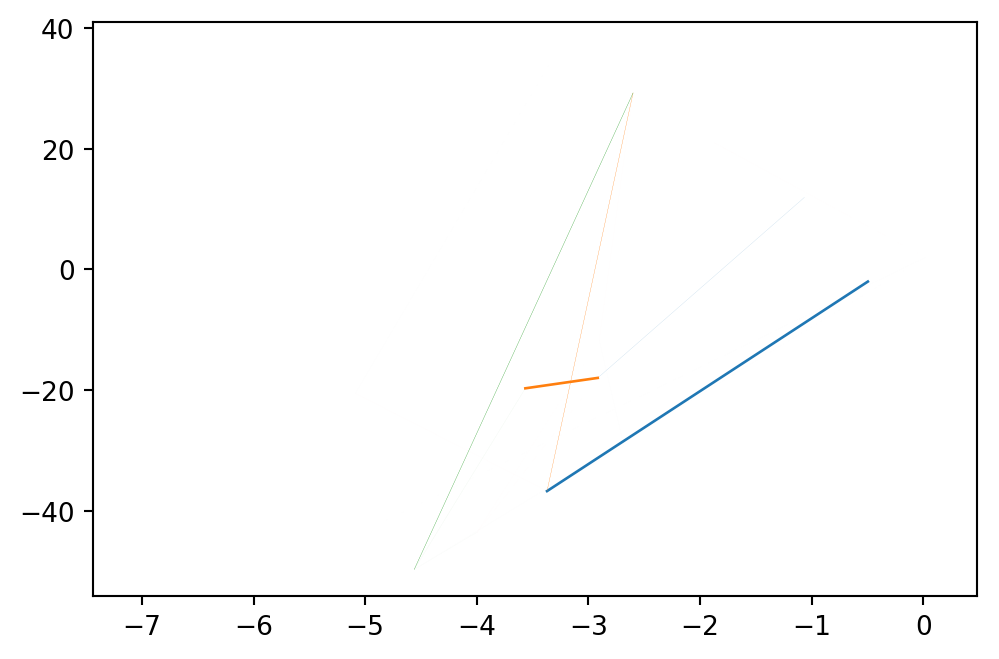

In [11]:
def draw_traj(opt, dendros, xbound=(-100,100), ybound=(-100,100)):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for t in range(len(dendros)-1):
        cur_d = dendros[t].branches
        next_d = dendros[t+1].branches
        links = softmax(opt[t], axis=1)[:, :-1]
        color = colors[t%len(colors)]
        for i, j in np.ndindex(*links.shape):
            x = [cur_d[i].loc[0], next_d[j].loc[0]]
            y = [cur_d[i].loc[1], next_d[j].loc[1]]
            if cur_d[i].vol < 2500000 and next_d[j].vol < 2500000:
                plt.plot(x, y, linewidth=links[i,j], color=color)
#     plt.xlim(xbound)
#     plt.ylim(ybound)
    plt.show()

plt.close()
draw_traj(links, dendros)

<class 'list'>


In [16]:
class TrackParams:
    
    def __init__(self):
        self.init_links = np.array([])
        self.optimal = None
        self.shapes = []
        self.link_skip = [0]
    
    def add_links(self, mat):
        self.shapes.append(mat.shape)
        skip = mat.size + self.link_skip[-1]
        self.link_skip.append(skip)
        self.init_links = np.concatenate((self.init_links, mat.flatten()))
    
    def get_links(self, params, frame_num):
        shape = self.shapes[frame_num]
        sz = np.prod(shape)
        skip = self.link_skip[frame_num]
        return params[skip:skip+sz].reshape(shape)
    
    def update(self, params):
        self.optimal = params

class Tracker:
    
    def __init__(self, dendrograms, thresh):
        self.frames = dendrograms
        self.separations = []
        self.params = TrackParams()
        for t in range(len(dendrograms)-1):
            cur_sz = dendrograms[t].size
            next_sz = dendrograms[t+1].size
            separation_mat = np.empty((2, cur_sz, next_sz))
            link_mat = np.zeros((cur_sz, next_sz))
            for i, j in np.ndindex(cur_sz, next_sz):
                sep = dendrograms[t+1].branches[j].loc - dendrograms[t].branches[i].loc
                separation_mat[:, i, j] = sep
                if np.linalg.norm(sep) < thresh:
                    link_mat[i, j] = 1
            self.params.add_links(link_mat)
            self.separations.append(separation_mat)
        self.masses = []
        for d in dendrograms:
            branch_mass = np.asarray([b.mass for b in d.branches])
            self.masses.append(branch_mass)
    
    def energy(self, params):            
        def momentums_in(frame_num):
            separation_mat = self.separations[frame_num-1]
            link_mat = self.params.get_links(params, frame_num-1)
            mass_in = self.masses[frame_num-1]
            mass_split = mass_in[:, None] * softmax(link_mat, axis=1)
            momentum = separation_mat * mass_split
            return jnp.sum(momentum, axis=1)
        
        def momentums_out(frame_num):
            separation_mat = self.separations[frame_num]
            link_mat = self.params.get_links(params, frame_num)
            mass_out = self.masses[frame_num]
            mass_split = mass_out[:, None] * softmax(link_mat, axis=1)
            momentum = separation_mat * mass_split
            return jnp.sum(momentum, axis=2)
            
        E = 0
        c0 = 1
        
        # also minimize entropy to prevent splitting
        
        for t in range(1, len(self.frames)-1):
            p1 = momentums_in(t)
            p2 = momentums_out(t)
            p1_norm = jnp.linalg.norm(p1, axis=0) + 1
            p2_norm = jnp.linalg.norm(p2, axis=0) + 1
            angle_term = -2 * jnp.sum(p1*p2, axis=0)/(p1_norm*p2_norm)
            inertia_term = p1_norm/p2_norm + p2_norm/p1_norm
            E += jnp.sum(angle_term + c0*inertia_term)
        
        return E
    
    def optimize(self):
        def callback(xk):
            print(self.energy(xk))
            self.params.update(xk)
        result = scipy.optimize.minimize(self.energy, self.params.init_links,
                                         args=(), method='CG', jac=grad(self.energy), tol=None,
                                         callback=callback)
        print(self.energy(result.x))
        print(result.message)
        self.params.update(result.x)